In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
sys.path.insert(0, '/home/olle/PycharmProjects/LODE/feature_segmentation/utils')

import plotting
plt.style.use('seaborn')

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties_naive.csv"
data_pd = pd.read_csv(data_file)
oct_meta_pd = pd.read_csv("/home/olle/PycharmProjects/LODE/workspace/sequence_data/oct_meta_information.csv")

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

In [3]:
# Packages you'll use in the function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

#### How many sequence are treated?

In [4]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 424


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

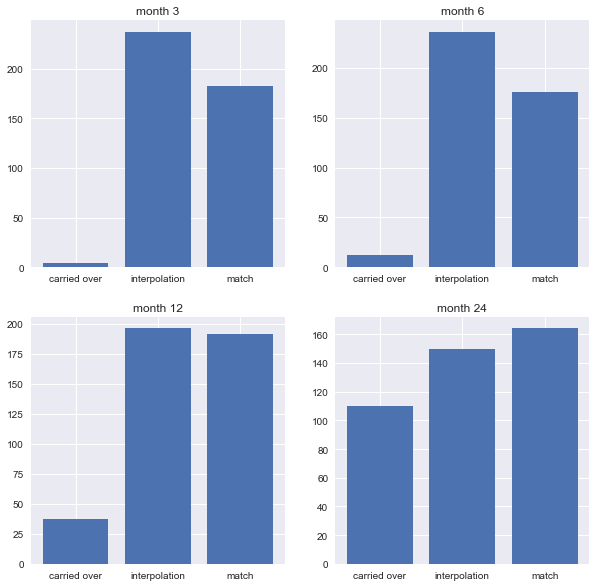

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

/home/olle/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/olle/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Time from carry over 6 months')

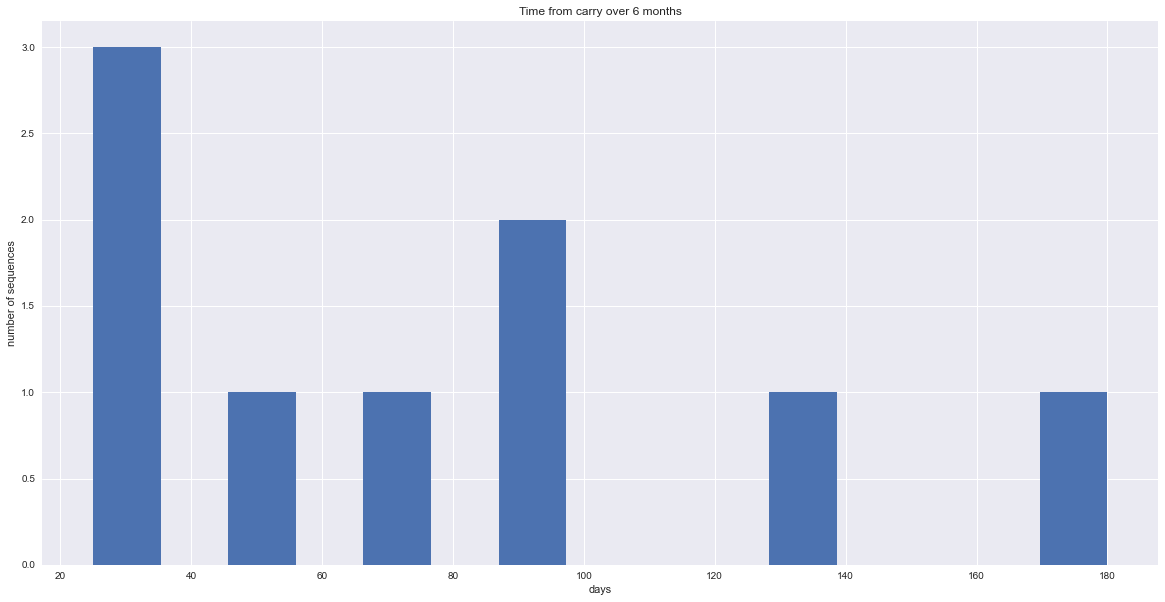

In [6]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

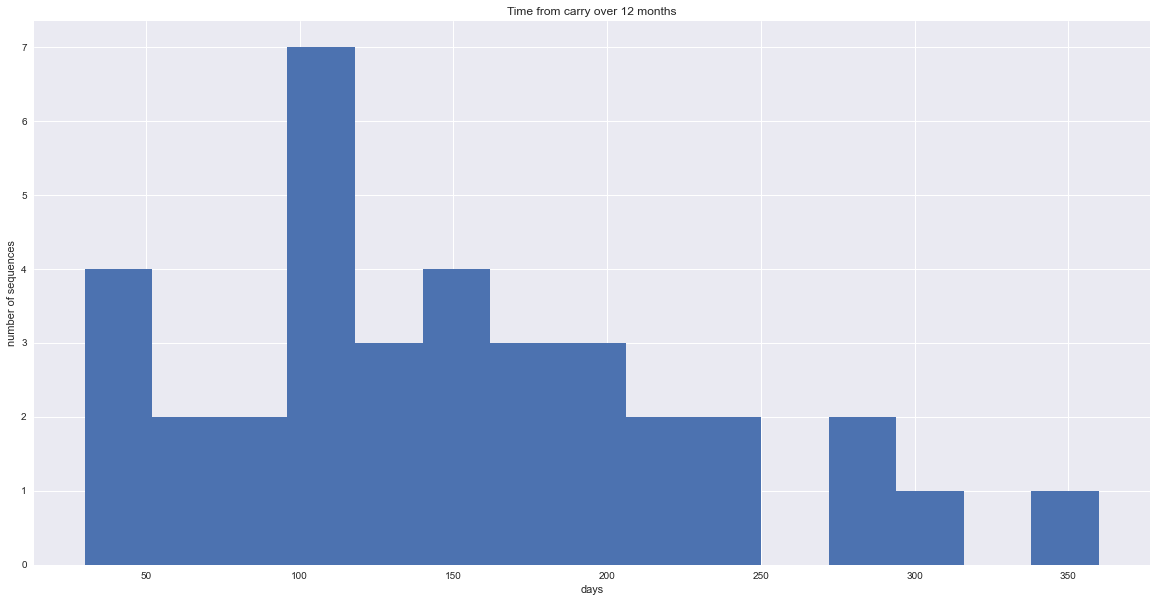

In [7]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

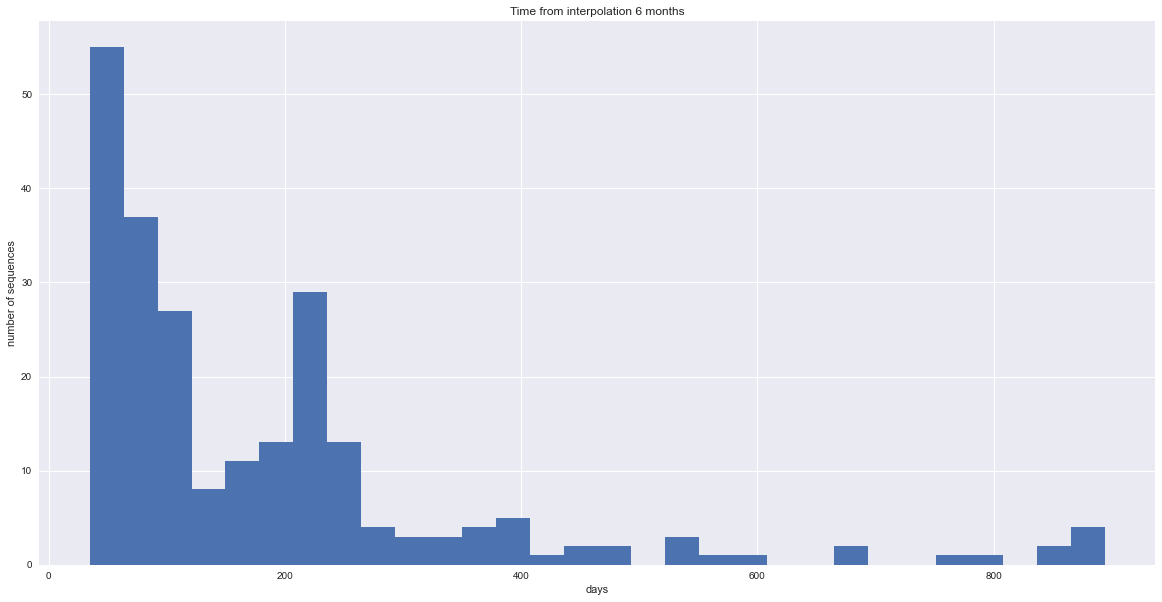

In [8]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

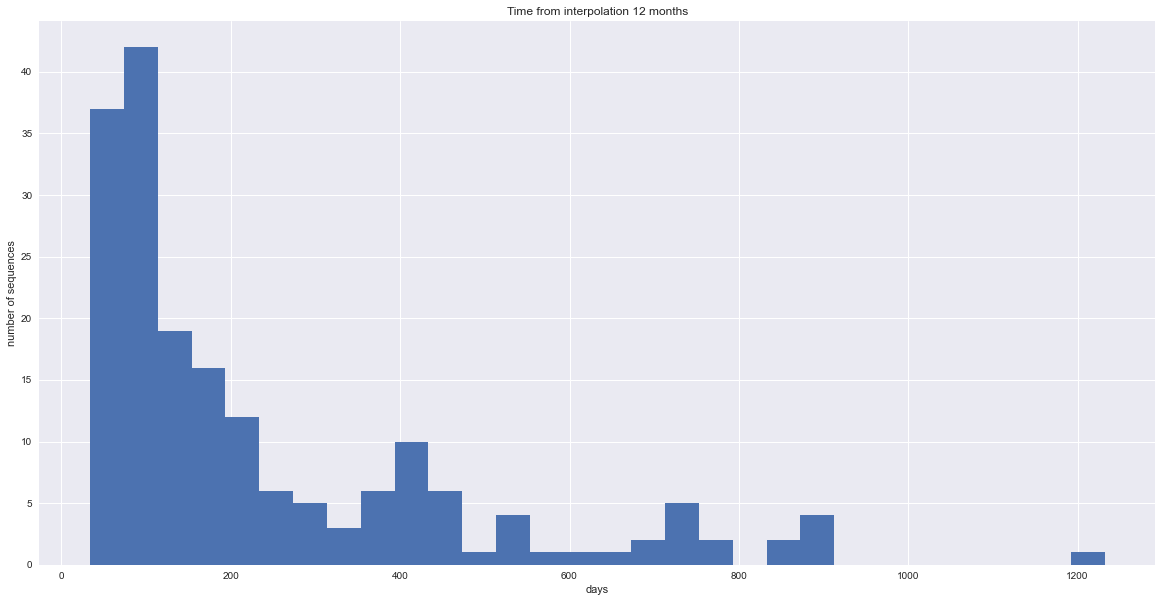

In [9]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [10]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))

Number of sequences starting as dry:  13
Number of sequences dry after 3 months:  17
Number of sequences dry after 6 months:  11
Number of sequences dry after 12 months:  17
Number of sequences dry after 24 months:  17


## Filter data based on time series eclusion criterias

In [11]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER

In [12]:
# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 3 months are: 234
Number of filtered sequences for 6 months are: 265
Number of filtered sequences for 12 months are: 254


## Filter statistics

In [13]:
print(np.sum(filter_1))
print(np.sum(filter_1&filter_3&filter_6&filter_12))
print(np.sum(filter_1&filter_6&filter_12))
print(np.sum(filter_1&filter_12))
print(np.sum(filter_1&filter_6))
print(np.sum(filter_1&filter_3))
print(np.sum(filter_1&filter_3&filter_6))
print(np.sum(filter_1&filter_3&filter_12))

395
131
175
243
254
225
185
156


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878

In [113]:
def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd*PIXEL_TO_VOLUME

def get_feature_dicts(times, table):
    feature_dict = {}
    for time in times:
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
    
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                       columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["seq"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    # filter all columns for the independent ones in list
    df.index = table["seq"]
    return df

In [16]:
def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features dependents
def get_seg_dependents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []

    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

### Factors associated with baseline VA

In [114]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = []
seg_times = [1]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = []

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_dependents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1])

independent_variables = injection_independents + seg_independents + va_independents
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_1"]

#### fit model

In [116]:

model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()
regression_summary = result_lin.summary()
reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

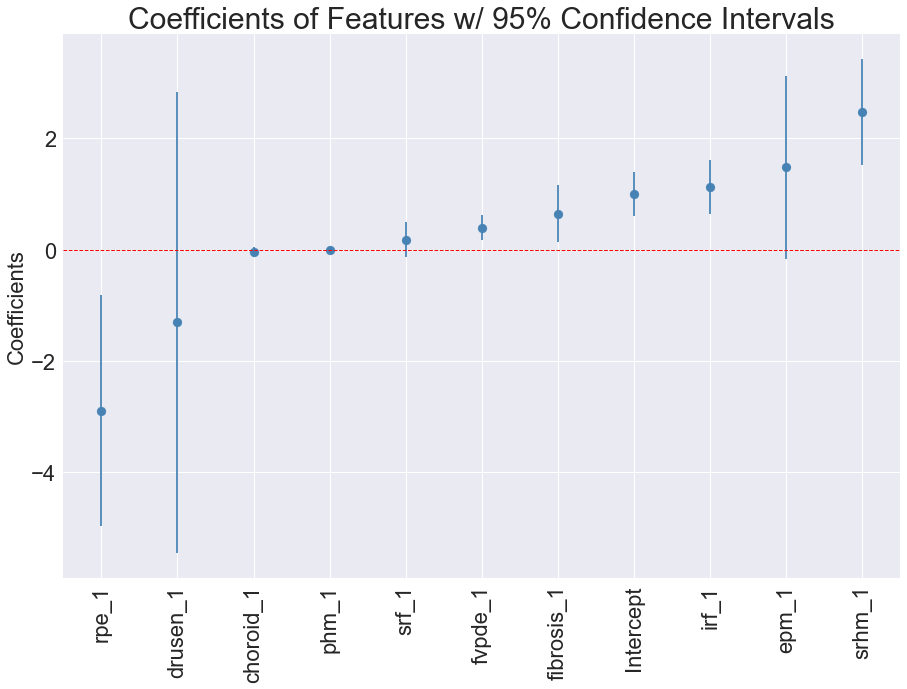

In [117]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [118]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.25328631194831486 mean predictor mae is:  0.31606383592373016


In [21]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     22.34
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           1.63e-30
Time:                        07:25:01   Log-Likelihood:                -129.69
No. Observations:                 395   AIC:                             279.4
Df Residuals:                     385   BIC:                             319.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0071      0.201      5.015      0.000       0.612       1.402
epm_1          1.4809      0.836      1.771      0.077      -0.163       3.125
irf_1          1.1220      0.248      4.517      0.000       0.634       1.610
srf_1          0.1793      0.161      1.110      0.267      -0.138       0.497
srhm_1         2.4772      0.484      5.119      0.000       1.526       3.429
rpe_1         -2.8965      1.056     -2.744      0.006      -4.972      -0.821
fvpde_1        0.3943      0.114      3.464      0.001       0.171       0.618
drusen_1      -1.3092      2.109     -0.621      0.535      -5.456       2.838
phm_1      -2.307e-16   2.41e-16     -0.956      0.339   -7.05e-16    2.44e-16
choroid_1     -0.0431      0.044     -0.986      0.325      -0.129       0.043
fibrosis_1     0.6440      0.262      2.461      0.014       0.130       1.158
==============================================================================
Omnibus:                       53.836   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.216
Skew:                           0.881   Prob(JB):                     3.81e-18
Kurtosis:                       4.330   Cond. No.                     2.55e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## One year Baseline Adata

In [119]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["12-1"]
seg_times = [1, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = [
                      # "epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      #"fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      #"fibrosis_12"
]

for col_to_remove in columns_to_exclude:
    independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"]

#### Fit linear model

In [120]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

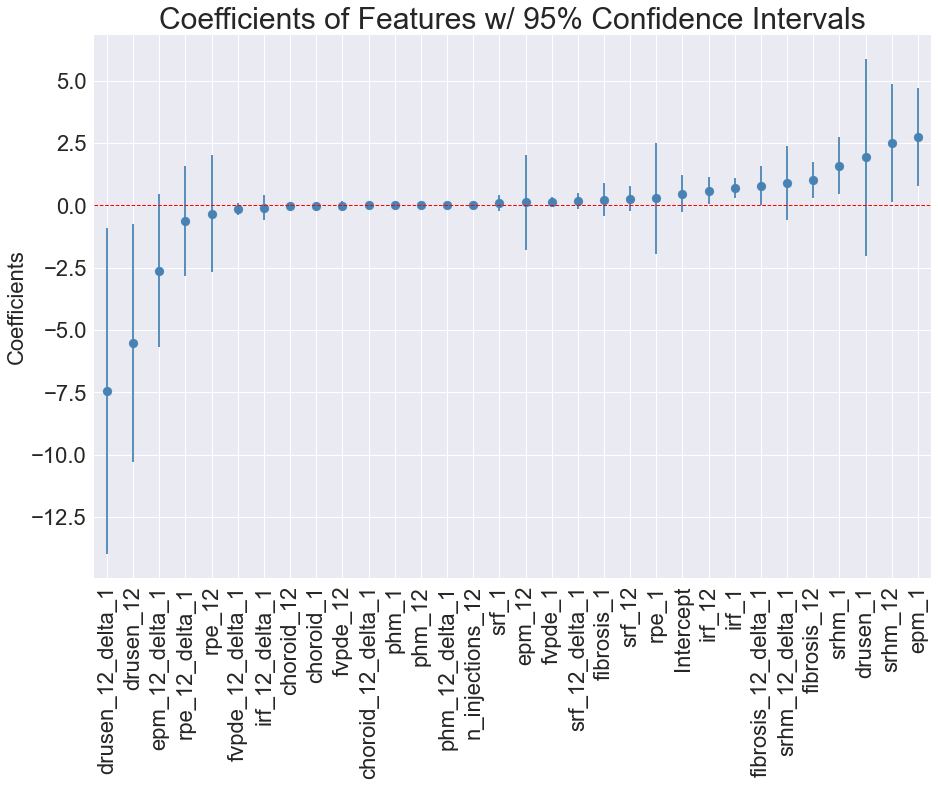

In [121]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [51]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     7.761
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           3.57e-16
Time:                        07:40:51   Log-Likelihood:                -71.468
No. Observations:                 243   AIC:                             182.9
Df Residuals:                     223   BIC:                             252.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4615      0.377      1.226      0.222      -0.280       1.204
n_injections_12       1.93e-05      0.007      0.003      0.998      -0.013       0.013
epm_1                   2.7374      1.001      2.735      0.007       0.765       4.710
epm_12                  0.1184      0.965      0.123      0.902      -1.783       2.020
epm_12_delta_1         -2.6190      1.551     -1.689      0.093      -5.675       0.437
irf_1                   0.6852      0.203      3.370      0.001       0.285       1.086
irf_12                  0.5854      0.277      2.115      0.036       0.040       1.131
irf_12_delta_1         -0.0998      0.257     -0.389      0.698      -0.606       0.406
srf_1                   0.0875      0.159      0.549      0.583      -0.226       0.401
srf_12                  0.2597      0.252      1.030      0.304      -0.237       0.757
srf_12_delta_1          0.1723      0.171      1.006      0.316      -0.165       0.510
srhm_1                  1.5960      0.583      2.738      0.007       0.447       2.745
srhm_12                 2.4975      1.198      2.084      0.038       0.136       4.859
srhm_12_delta_1         0.9015      0.748      1.205      0.229      -0.573       2.376
rpe_1                   0.2817      1.131      0.249      0.803      -1.947       2.510
rpe_12                 -0.3436      1.189     -0.289      0.773      -2.687       2.000
rpe_12_delta_1         -0.6253      1.116     -0.560      0.576      -2.826       1.575
fvpde_1                 0.1401      0.099      1.414      0.159      -0.055       0.335
fvpde_12               -0.0121      0.102     -0.119      0.905      -0.213       0.188
fvpde_12_delta_1       -0.1522      0.126     -1.207      0.229      -0.401       0.096
drusen_1                1.9179      1.997      0.961      0.338      -2.017       5.853
drusen_12              -5.5169      2.425     -2.275      0.024     -10.295      -0.739
drusen_12_delta_1      -7.4348      3.318     -2.241      0.026     -13.973      -0.896
phm_1                        0          0        nan        nan           0           0
phm_12                       0          0        nan        nan           0           0
phm_12_delta_1               0          0        nan        nan           0           0
choroid_1              -0.0382      0.038     -1.018      0.310      -0.112       0.036
choroid_12             -0.0419      0.039     -1.073      0.284      -0.119       0.035
choroid_12_delta_1     -0.0037      0.047     -0.079      0.937      -0.096       0.088
fibrosis_1              0.2219      0.340      0.653      0.515      -0.448       0.892
fibrosis_12             1.0039      0.369      2.722      0.007       0.277       1.731
fibrosis_12_delta_1     0.7820      0.400      1.954      0.052      -0.007       1.571
===

In [122]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)

mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.2543441929913522 mean predictor mae is:  0.31794366452822415


# Which features explain 12 month VA

In [160]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-1"]
seg_times = [1, 3, 6, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = ["3-1","6-1"]
va_times = [1, 3, 6, 12]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3, 6, 12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 6, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", 
                      
                      #"epm_6", "irf_6", "srf_6", "srhm_6", "rpe_6", 
                      #"fvpde_6", "drusen_6", "phm_6", "choroid_6", "fibrosis_6",
                      
                      #"epm_3", "irf_3", "srf_3", "srhm_3", "rpe_3", 
                      #"fvpde_3", "drusen_3", "phm_3", "choroid_3", "fibrosis_3",
                      
                      #"cur_va_rounded_3", 
                      #"cur_va_rounded_6", 
                      "cur_va_rounded_12",
                      
                      #"n_injections_3", 
                      #"n_injections_6",
                      #"n_injections_12"
                     
                     ]

'''
abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)
'''
independent_variables = independent_variables #+ ["regular_treatment", "va_3month_improvement"]

for col_to_remove in columns_to_exclude:
    if col_to_remove in independent_variables:
        independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"]


model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]


from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [df_regression.cur_va_rounded_1.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

regression_summary

model mae is:  0.09806082979704697 mean predictor mae is:  0.3322549194480272


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     24.66
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           3.45e-34
Time:                        08:28:16   Log-Likelihood:                 77.096
No. Observations:                 131   AIC:                            -86.19
Df Residuals:                      97   BIC:                             11.56
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.8003      0.413     -1.936      0.056      -1.621       0.020
n_injections_3        -0.0422      0.023     -1.812      0.073      -0.088       0.004
n_injections_6         0.0249      0.024      1.023      0.309      -0.023       0.073
n_injections_12       -0.0108      0.009     -1.166      0.247      -0.029       0.008
epm_1                  1.6997      0.796      2.136      0.035       0.120       3.279
epm_3                 -2.0989      2.381     -0.882      0.380      -6.824       2.626
epm_6                  0.8362      2.272      0.368      0.714      -3.672       5.345
epm_3_delta_1         -3.7986      2.649     -1.434      0.155      -9.056       1.459
epm_6_delta_1         -0.8635      2.465     -0.350      0.727      -5.757       4.030
irf_1                 -0.1254      0.125     -1.003      0.318      -0.373       0.123
irf_3                 -0.3653      0.282     -1.298      0.198      -0.924       0.193
irf_6                  0.2494      0.274      0.910      0.365      -0.295       0.794
irf_3_delta_1         -0.2399      0.263     -0.913      0.363      -0.761       0.282
irf_6_delta_1          0.3747      0.266      1.411      0.161      -0.152       0.902
srf_1                 -0.0399      0.318     -0.126      0.900      -0.670       0.591
srf_3                 -0.1466      0.713     -0.206      0.838      -1.562       1.269
srf_6                  0.2684      0.618      0.434      0.665      -0.959       1.496
srf_3_delta_1         -0.1068      0.533     -0.200      0.842      -1.164       0.950
srf_6_delta_1          0.3083      0.479      0.643      0.522      -0.643       1.259
srhm_1                 0.0489      0.483      0.101      0.920      -0.910       1.008
srhm_3                 1.8967      1.193      1.589      0.115      -0.472       4.265
srhm_6                -0.4607      1.333     -0.346      0.730      -3.106       2.185
srhm_3_delta_1         1.8477      1.011      1.827      0.071      -0.160       3.855
srhm_6_delta_1        -0.5096      1.050     -0.485      0.629      -2.594       1.575
rpe_1                  2.3671      0.810      2.921      0.004       0.759       3.975
rpe_3                  0.9810      1.241      0.790      0.431      -1.483       3.445
rpe_6                  1.5840      1.078      1.470      0.145      -0.555       3.723
rpe_3_delta_1         -1.3861      1.110     -1.249      0.215      -3.590       0.817
rpe_6_delta_1         -0.7832      0.959     -0.817      0.416      -2.687       1.120
fvpde_1               -0.0656      0.061     -1.085      0.281      -0.186       0.054
fvpde_3               -0.2423      0.130     -1.860      0.066      -0.501       0.016
fvpde_6                0.0538      0.145      0.371      0.711      -0.234       0.341
fvpde_3_delta_1       -0.1766      0.1

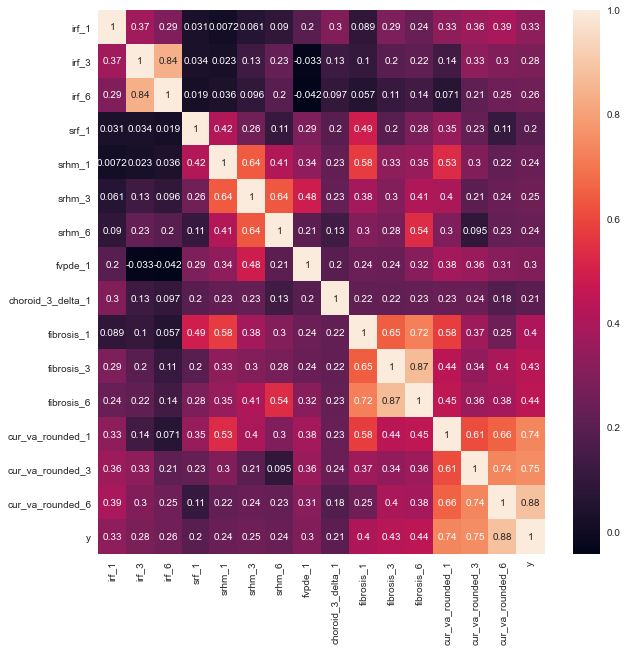

In [161]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

df = df_regression

corrMatrix = df.corr()

# filter corr table
corr_filter = corrMatrix.loc["y",:] > 0.2

filtered_columns = corrMatrix_filtered.columns.tolist()

corrMatrix_filtered = corrMatrix.loc[corr_filter, corr_filter]

sn.heatmap(corrMatrix_filtered, annot=True)
plt.show()


103

0it [00:00, ?it/s]

Number of cvs set to number of patients:  10
y not in list
cur_va_rounded_3 not in list
cur_va_rounded_6 not in list


10it [00:07,  1.32it/s]

Model R2 over 10 cross val runs is: 0.3871134246207173


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'irf_1'),
  Text(1, 0, 'irf_3'),
  Text(2, 0, 'irf_6'),
  Text(3, 0, 'srf_1'),
  Text(4, 0, 'srhm_1'),
  Text(5, 0, 'srhm_3'),
  Text(6, 0, 'srhm_6'),
  Text(7, 0, 'fvpde_1'),
  Text(8, 0, 'choroid_3_delta_1'),
  Text(9, 0, 'fibrosis_1'),
  Text(10, 0, 'fibrosis_3'),
  Text(11, 0, 'fibrosis_6'),
  Text(12, 0, 'cur_va_rounded_1')])

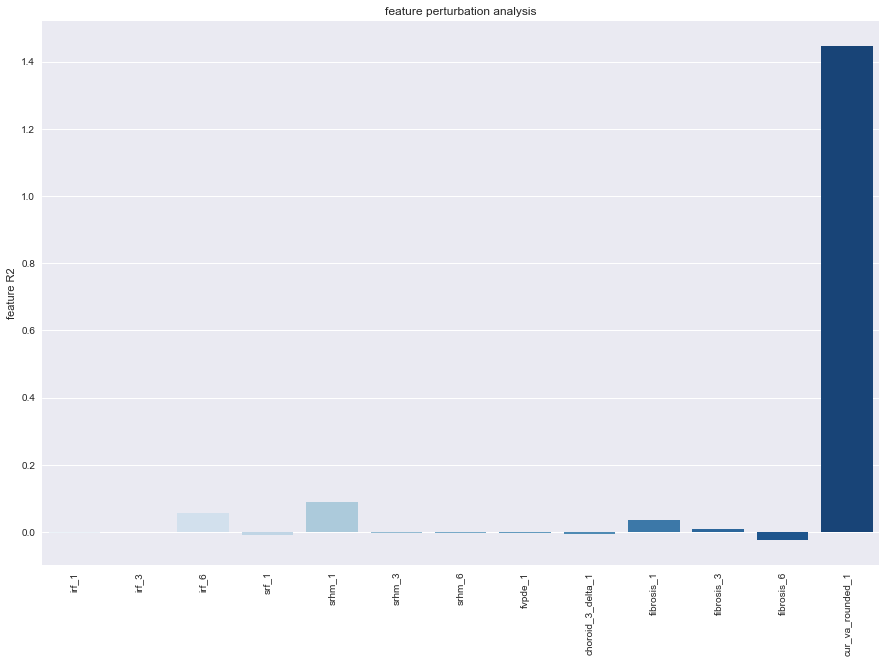

In [215]:
## Permutation test
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

N_CROSS_VALIDATIONS =  10 #np.unique(np.array(patient_ids)).shape[0]

print("Number of cvs set to number of patients: ", N_CROSS_VALIDATIONS)

patient_ids = [id_.replace("_R", "").replace("_L", "") for id_ in df_regression.index.tolist()]

df_regression_model = df_regression.reset_index()

try:
    filtered_columns.remove("y")
except:
    print("y not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_3')
except:
    print("cur_va_rounded_3 not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_6')
except:
    print("cur_va_rounded_6 not in list")
    
    
X = df_regression_model[filtered_columns]
y = df_regression_model["y"]

gss = GroupShuffleSplit(n_splits=N_CROSS_VALIDATIONS, train_size=.7)
gss.get_n_splits()

gss.get_n_splits()

importance_scores = np.zeros(len(filtered_columns))
model_r2 = 0

for train_ids, test_ids in tqdm(gss.split(X, y, patient_ids)):
    X_train = X.loc[train_ids,:]
    X_val = X.loc[test_ids,:]

    y_train = y[train_ids]
    y_val = y[test_ids] 

    model = Ridge(alpha=1e-2).fit(X_train, y_train)
    model_r2 += model.score(X_val, y_val)

    from sklearn.inspection import permutation_importance
    r = permutation_importance(model, X_val, y_val,
                               n_repeats=30)
    
    importance_scores += r.importances_mean

# average importance scores over runs
importance_scores /= N_CROSS_VALIDATIONS

print(f"Model R2 over {N_CROSS_VALIDATIONS} cross val runs is: {model_r2 / N_CROSS_VALIDATIONS}")

x = filtered_columns
y = importance_scores

#### feature importance plot
plt.figure(figsize=(15, 10))
sns.barplot(x, y, palette="Blues")
plt.ylabel("feature R2")
plt.title("feature perturbation analysis")
plt.xticks(rotation=90)

# Factors associated with Fibrosis progression

In [27]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["12-1"]
seg_times = [1, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", "fibrosis_12_delta_1"]

for col_to_remove in columns_to_exclude:
    independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["fibrosis_12"] - abt["fibrosis_1"]

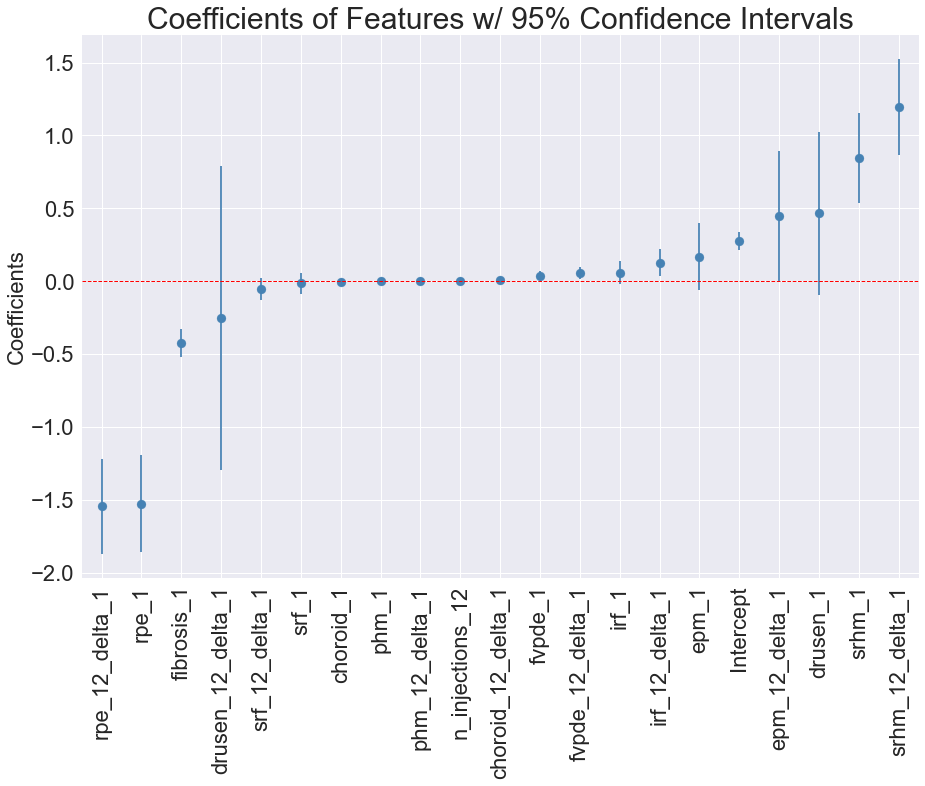

In [28]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

## 3 month progression Influence

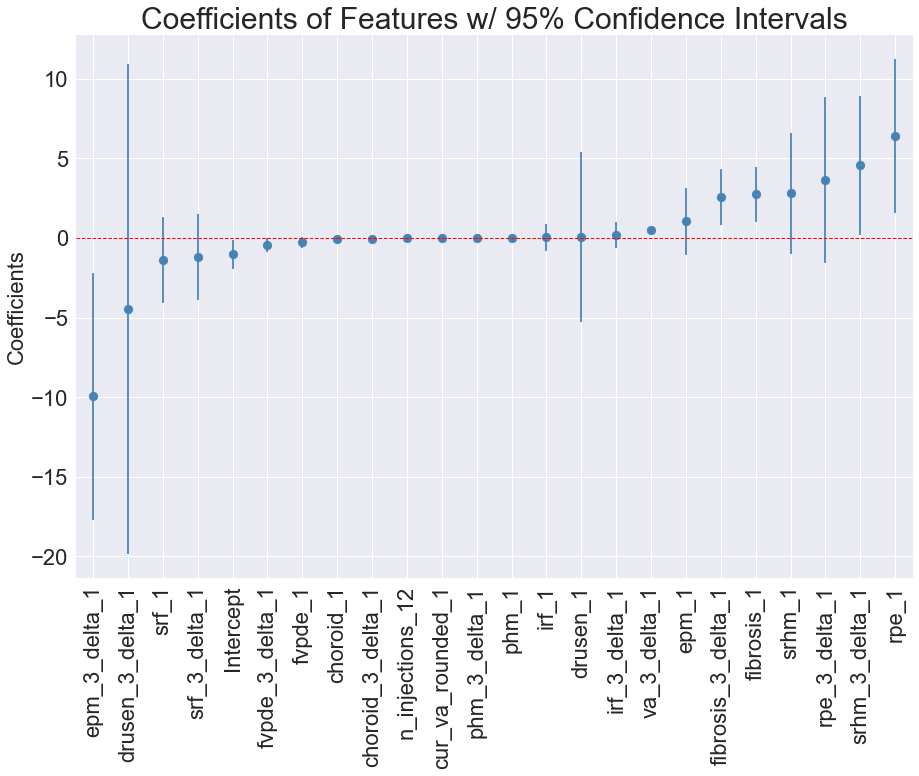

In [29]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1"]
seg_times = [1, 3, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = ["3-1"]
va_times = [1, 3, 6]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 6, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12",
                      "epm_3", "irf_3", "srf_3", "srhm_3", "rpe_3", 
                      "fvpde_3", "drusen_3", "phm_3", "choroid_3", 
                      "fibrosis_3",
                      "fibrosis_12", "fibrosis_12_delta_1", "cur_va_rounded_6", "va_6_delta_1",
                      "cur_va_rounded_3"]

for col_to_remove in columns_to_exclude:
    if col_to_remove in independent_variables:
        independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"] - abt["cur_va_rounded_1"]

model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [30]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     9.011
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           1.45e-15
Time:                        07:25:03   Log-Likelihood:                 30.563
No. Observations:                 131   AIC:                            -17.13
Df Residuals:                     109   BIC:                             46.13
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0356      0.448     -2.310      0.023      -1.924      -0.147
n_injections_12       -0.0102      0.007     -1.404      0.163      -0.025       0.004
epm_1                  1.0407      1.071      0.972      0.333      -1.082       3.163
epm_3_delta_1         -9.9518      3.907     -2.547      0.012     -17.696      -2.207
irf_1                  0.0437      0.426      0.103      0.918      -0.800       0.888
irf_3_delta_1          0.1848      0.407      0.454      0.651      -0.623       0.992
srf_1                 -1.3752      1.353     -1.017      0.312      -4.057       1.306
srf_3_delta_1         -1.1991      1.365     -0.879      0.382      -3.904       1.506
srhm_1                 2.8131      1.920      1.465      0.146      -0.992       6.618
srhm_3_delta_1         4.5686      2.200      2.077      0.040       0.209       8.928
rpe_1                  6.4024      2.432      2.633      0.010       1.583      11.222
rpe_3_delta_1          3.6444      2.643      1.379      0.171      -1.594       8.882
fvpde_1               -0.2768      0.168     -1.651      0.102      -0.609       0.055
fvpde_3_delta_1       -0.4260      0.227     -1.879      0.063      -0.875       0.023
drusen_1               0.0584      2.686      0.022      0.983      -5.265       5.382
drusen_3_delta_1      -4.4644      7.754     -0.576      0.566     -19.832      10.903
phm_1               3.727e-15   1.47e-15      2.537      0.013    8.15e-16    6.64e-15
phm_3_delta_1      -9.249e-16   1.44e-15     -0.640      0.523   -3.79e-15    1.94e-15
choroid_1             -0.0740      0.051     -1.439      0.153      -0.176       0.028
choroid_3_delta_1     -0.0539      0.069     -0.780      0.437      -0.191       0.083
fibrosis_1             2.7503      0.873      3.149      0.002       1.019       4.481
fibrosis_3_delta_1     2.5572      0.888      2.880      0.005       0.797       4.317
cur_va_rounded_1      -0.0101      0.078     -0.129      0.897      -0.165       0.144
va_3_delta_1           0.5064      0.077      6.601      0.000       0.354       0.658
==============================================================================
Omnibus:                       30.973   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.725
Skew:                           0.836   Prob(JB):                     7.33e-21
Kurtosis:                       6.767   Cond. No.                     6.57e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)

mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.13029876405849156 mean predictor mae is:  0.20991586765838524


In [32]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     9.011
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           1.45e-15
Time:                        07:25:03   Log-Likelihood:                 30.563
No. Observations:                 131   AIC:                            -17.13
Df Residuals:                     109   BIC:                             46.13
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0356      0.448     -2.310      0.023      -1.924      -0.147
n_injections_12       -0.0102      0.007     -1.404      0.163      -0.025       0.004
epm_1                  1.0407      1.071      0.972      0.333      -1.082       3.163
epm_3_delta_1         -9.9518      3.907     -2.547      0.012     -17.696      -2.207
irf_1                  0.0437      0.426      0.103      0.918      -0.800       0.888
irf_3_delta_1          0.1848      0.407      0.454      0.651      -0.623       0.992
srf_1                 -1.3752      1.353     -1.017      0.312      -4.057       1.306
srf_3_delta_1         -1.1991      1.365     -0.879      0.382      -3.904       1.506
srhm_1                 2.8131      1.920      1.465      0.146      -0.992       6.618
srhm_3_delta_1         4.5686      2.200      2.077      0.040       0.209       8.928
rpe_1                  6.4024      2.432      2.633      0.010       1.583      11.222
rpe_3_delta_1          3.6444      2.643      1.379      0.171      -1.594       8.882
fvpde_1               -0.2768      0.168     -1.651      0.102      -0.609       0.055
fvpde_3_delta_1       -0.4260      0.227     -1.879      0.063      -0.875       0.023
drusen_1               0.0584      2.686      0.022      0.983      -5.265       5.382
drusen_3_delta_1      -4.4644      7.754     -0.576      0.566     -19.832      10.903
phm_1               3.727e-15   1.47e-15      2.537      0.013    8.15e-16    6.64e-15
phm_3_delta_1      -9.249e-16   1.44e-15     -0.640      0.523   -3.79e-15    1.94e-15
choroid_1             -0.0740      0.051     -1.439      0.153      -0.176       0.028
choroid_3_delta_1     -0.0539      0.069     -0.780      0.437      -0.191       0.083
fibrosis_1             2.7503      0.873      3.149      0.002       1.019       4.481
fibrosis_3_delta_1     2.5572      0.888      2.880      0.005       0.797       4.317
cur_va_rounded_1      -0.0101      0.078     -0.129      0.897      -0.165       0.144
va_3_delta_1           0.5064      0.077      6.601      0.000       0.354       0.658
==============================================================================
Omnibus:                       30.973   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.725
Skew:                           0.836   Prob(JB):                     7.33e-21
Kurtosis:                       6.767   Cond. No.                     6.57e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.13029876405849156 mean predictor mae is:  0.20991586765838524


## Top features for 12 month VA progression

In [34]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1"]
seg_times = [1, 3, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = ["3-1"]
va_times = [1, 3, 6]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3, 12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", "epm_3", "irf_3", "srf_3", "srhm_3", "rpe_3", 
                      "fvpde_3", "drusen_3", "phm_3", "choroid_3", 
                      "fibrosis_3","cur_va_rounded_6", "va_3_delta_1",
                      "cur_va_rounded_3"]

'''
abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)
'''
independent_variables = independent_variables #+ ["regular_treatment", "va_3month_improvement"]

for col_to_remove in columns_to_exclude:
    if col_to_remove in independent_variables:
        independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"] - abt["cur_va_rounded_1"]

#### handcrafted features

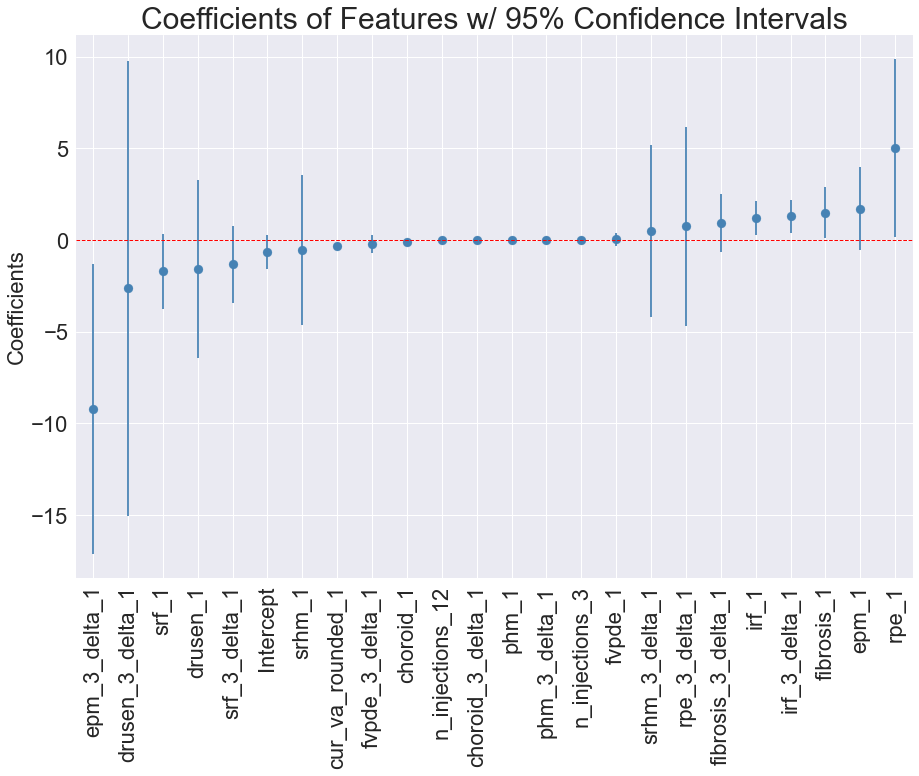

In [35]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [36]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     5.029
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           2.48e-09
Time:                        07:25:03   Log-Likelihood:                 5.4881
No. Observations:                 156   AIC:                             33.02
Df Residuals:                     134   BIC:                             100.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.6573      0.458     -1.434      0.154      -1.564       0.249
n_injections_3         0.0129      0.012      1.045      0.298      -0.012       0.037
n_injections_12       -0.0117      0.009     -1.303      0.195      -0.029       0.006
epm_1                  1.7075      1.151      1.483      0.140      -0.569       3.984
epm_3_delta_1         -9.1933      4.000     -2.298      0.023     -17.105      -1.282
irf_1                  1.2106      0.460      2.630      0.010       0.300       2.121
irf_3_delta_1          1.2912      0.450      2.866      0.005       0.400       2.182
srf_1                 -1.7096      1.033     -1.655      0.100      -3.752       0.333
srf_3_delta_1         -1.3281      1.053     -1.261      0.209      -3.411       0.755
srhm_1                -0.5508      2.072     -0.266      0.791      -4.648       3.547
srhm_3_delta_1         0.5002      2.372      0.211      0.833      -4.191       5.192
rpe_1                  5.0091      2.450      2.044      0.043       0.163       9.856
rpe_3_delta_1          0.7488      2.738      0.273      0.785      -4.667       6.164
fvpde_1                0.0414      0.181      0.229      0.819      -0.316       0.399
fvpde_3_delta_1       -0.2022      0.247     -0.820      0.414      -0.690       0.286
drusen_1              -1.5787      2.460     -0.642      0.522      -6.444       3.286
drusen_3_delta_1      -2.6258      6.275     -0.418      0.676     -15.036       9.785
phm_1               3.184e-16   5.93e-15      0.054      0.957   -1.14e-14     1.2e-14
phm_3_delta_1       2.001e-15   5.66e-15      0.353      0.724    -9.2e-15    1.32e-14
choroid_1             -0.1231      0.058     -2.130      0.035      -0.238      -0.009
choroid_3_delta_1     -0.0105      0.071     -0.147      0.883      -0.152       0.131
fibrosis_1             1.4924      0.703      2.123      0.036       0.102       2.883
fibrosis_3_delta_1     0.9253      0.802      1.154      0.250      -0.660       2.511
cur_va_rounded_1      -0.3377      0.065     -5.200      0.000      -0.466      -0.209
==============================================================================
Omnibus:                       12.667   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               22.071
Skew:                           0.381   Prob(JB):                     1.61e-05
Kurtosis:                       4.678   Cond. No.                     4.55e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.25e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.17688936167768396 mean predictor mae is:  0.21527575789000844


Text(0.5, 1.0, 'mae decrease with time information')

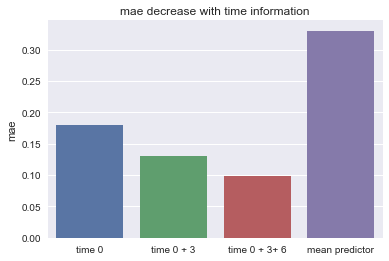

In [41]:
#### MAE plot
y = [0.18, 0.13, 0.098, 0.33]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6", "mean predictor"]
sns.barplot(x, y)
plt.ylabel("mae")
plt.title("mae decrease with time information")

Text(0.5, 1.0, 'R2 increase with time information')

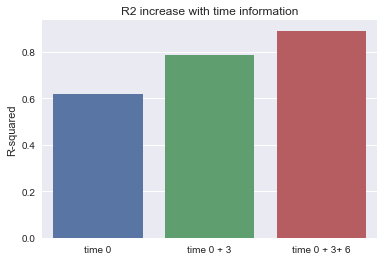

In [42]:
#### R2 plot
y = [0.616, 0.785, 0.89]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6"]
sns.barplot(x, y)
plt.ylabel("R-squared")
plt.title("R2 increase with time information")

## 3 month improvement groups

In [43]:
ax = sns.countplot(x="va_3month_improvement", data=abt_plt)
plt.legend()
plt.xticks(ticks=[0,1,2], labels=["x > 0", "0 > x > - 0.2", "x > - 0.2"])

NameError: name 'abt_plt' is not defined

In [ ]:
abt_plt

In [ ]:
abt_plt = abt[["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12", "va_3_delta_1"]]

abt_plt["va_3month_improvement"] = None

strong_f = abt_plt["va_3_delta_1"] <= -0.2
weak_f = (abt_plt["va_3_delta_1"] <= 0) & (abt_plt["va_3_delta_1"] > -0.2)
no_f =  abt_plt["va_3_delta_1"] > 0

abt_plt["va_3month_improvement"][strong_f] = "strong"
abt_plt["va_3month_improvement"][weak_f] = "weak"
abt_plt["va_3month_improvement"][no_f] = "no"

abt_plt_long = abt_plt.melt(id_vars=["va_3month_improvement"], 
                            value_vars=["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12"])

dict_ = {'cur_va_rounded_1' : 'month 1', 'cur_va_rounded_3' : 'month 3', 'cur_va_rounded_12' : 'month 12'}

# Remap the values of the dataframe 
abt_plt_long = abt_plt_long.replace({"variable": dict_})

plt.figure(figsize=(10,5))
sns.lineplot(data=abt_plt_long, x="variable", y="value", hue="va_3month_improvement")
plt.ylabel("visual acuity")

In [ ]:

abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# strong
sns.histplot(ax=axes[0], x=abt[abt.va_3month_improvement == 2].cur_va_rounded_1)
axes[0].set_title("strong improvement")

# weak
sns.histplot(ax=axes[1], x=abt[abt.va_3month_improvement == 1].cur_va_rounded_1)
axes[1].set_title("weak improvement")

# no
sns.histplot(ax=axes[2], x=abt[abt.va_3month_improvement == 0].cur_va_rounded_1)
axes[2].set_title("no improvement")

In [ ]:
sig_columns = ["y","va_3month_improvement", "srhm_3_delta_1", "cur_va_rounded_1", "va_3_delta_1"]

sns.pairplot(df_regression[sig_columns])

In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    k = 0 
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        print("Current score is: ", current_score, "for iteration ", k)
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score <= best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        k +=1
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
        
    model = smf.ols(formula, data).fit()
    return model

fs_model = forward_selected(df_regression, response="y")